In [4]:
import os
import shutil
import random
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

random.seed(108)

# Input & output paths
input_folder = './train/Final Train Dataset'
working_dir = './process'
images_dir = os.path.join(working_dir, 'images')
annotations_dir = os.path.join(working_dir, 'annotations')
labels_dir = os.path.join(working_dir, 'labels')

for d in [working_dir, images_dir, annotations_dir, labels_dir]:
    os.makedirs(d, exist_ok=True)


2. Data Preparation: Copy & Clean Dataset

In [5]:
# Get files
all_files = os.listdir(input_folder)
images = [f for f in all_files if f.lower().endswith('.jpg')]
annotations = [f for f in all_files if f.lower().endswith('.xml')]

# Copy
for img in images:
    shutil.copy(os.path.join(input_folder, img), os.path.join(images_dir, img))
for ann in annotations:
    shutil.copy(os.path.join(input_folder, ann), os.path.join(annotations_dir, ann))

# Match valid pairs only
image_names = {os.path.splitext(img)[0] for img in os.listdir(images_dir)}
ann_names = {os.path.splitext(ann)[0] for ann in os.listdir(annotations_dir)}

for img in os.listdir(images_dir):
    if os.path.splitext(img)[0] not in ann_names:
        os.remove(os.path.join(images_dir, img))

for ann in os.listdir(annotations_dir):
    if os.path.splitext(ann)[0] not in image_names:
        os.remove(os.path.join(annotations_dir, ann))

print(f"Matched images: {len(os.listdir(images_dir))}")
print(f"Matched annotations: {len(os.listdir(annotations_dir))}")


Matched images: 2987
Matched annotations: 2987


Convert Annotations (XML → YOLOv11 txt)

In [6]:
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm

selected_classes = ['car', 'bus', 'truck', 'motorbike']
class_name_to_id_mapping = {cls: idx for idx, cls in enumerate(selected_classes)}

# XML parser (safe with try/except)
def extract_info_from_xml(xml_file):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        info_dict = {'bboxes': [], 'filename': None, 'image_size': None}
        
        for elem in root:
            if elem.tag == "filename":
                info_dict['filename'] = elem.text
            elif elem.tag == "size":
                w, h, d = [int(subelem.text) for subelem in elem]
                info_dict['image_size'] = (w, h, d)
            elif elem.tag == "object":
                bbox = {}
                for subelem in elem:
                    if subelem.tag == "name" and subelem.text in selected_classes:
                        bbox["class"] = subelem.text
                    elif subelem.tag == "bndbox" and "class" in bbox:
                        for subsubelem in subelem:
                            bbox[subsubelem.tag] = int(subsubelem.text)
                if 'class' in bbox:
                    info_dict['bboxes'].append(bbox)
        
        return info_dict if info_dict['filename'] else None
    
    except ET.ParseError:
        print(f"Skipping corrupted XML: {xml_file}")
        return None
    except Exception as e:
        print(f"Error processing {xml_file}: {e}")
        return None

# Convert to YOLOv11
def convert_to_yolov11(info_dict, txt_path):
    lines = []
    if not info_dict or not info_dict['bboxes']:
        open(txt_path, 'w').close()
        return
    iw, ih, _ = info_dict['image_size']
    for b in info_dict["bboxes"]:
        cls_id = class_name_to_id_mapping[b["class"]]
        cx = (b["xmin"] + b["xmax"]) / 2 / iw
        cy = (b["ymin"] + b["ymax"]) / 2 / ih
        w = (b["xmax"] - b["xmin"]) / iw
        h = (b["ymax"] - b["ymin"]) / ih
        lines.append(f"{cls_id} {cx:.4f} {cy:.4f} {w:.4f} {h:.4f}")
    with open(txt_path, 'w') as f:
        f.write("\n".join(lines))

# Process all XML files
xml_files = [os.path.join(annotations_dir, f) for f in os.listdir(annotations_dir) if f.endswith('.xml')]
valid_image_files, valid_label_files = [], []

for xml_file in tqdm(xml_files):
    info_dict = extract_info_from_xml(xml_file)
    if info_dict:
        img_name = info_dict['filename']
        img_path = os.path.join(images_dir, img_name)
        txt_name = img_name.replace('.jpg', '.txt')
        txt_path = os.path.join(labels_dir, txt_name)
        if os.path.exists(img_path):
            convert_to_yolov11(info_dict, txt_path)
            valid_image_files.append(img_path)
            valid_label_files.append(txt_path)

print(f"Final pairs: {len(valid_image_files)}")


  6%|▌         | 168/2987 [00:01<00:23, 120.06it/s]

Skipping corrupted XML: ./process\annotations\231.xml


100%|██████████| 2987/2987 [00:20<00:00, 142.37it/s]

Final pairs: 2732


In [7]:
train_imgs, temp_imgs, train_lbls, temp_lbls = train_test_split(valid_image_files, valid_label_files, test_size=0.2, random_state=42)
val_imgs, test_imgs, val_lbls, test_lbls = train_test_split(temp_imgs, temp_lbls, test_size=0.5, random_state=42)

def make_dirs(base, sub):
    path = os.path.join(base, sub)
    os.makedirs(path, exist_ok=True)
    return path

train_img_dir = make_dirs(images_dir, "train")
val_img_dir = make_dirs(images_dir, "val")
test_img_dir = make_dirs(images_dir, "test")
train_lbl_dir = make_dirs(labels_dir, "train")
val_lbl_dir = make_dirs(labels_dir, "val")
test_lbl_dir = make_dirs(labels_dir, "test")

def move_files(files, dest):
    for f in files:
        if not os.path.exists(f): continue
        fname = os.path.basename(f)
        shutil.move(f, os.path.join(dest, fname))

move_files(train_imgs, train_img_dir)
move_files(val_imgs, val_img_dir)
move_files(test_imgs, test_img_dir)
move_files(train_lbls, train_lbl_dir)
move_files(val_lbls, val_lbl_dir)
move_files(test_lbls, test_lbl_dir)

yaml_path = os.path.join(working_dir, 'vehicle_data.yaml')
with open(yaml_path, 'w') as f:
    f.write(f"""
train: {train_img_dir}
val: {val_img_dir}
test: {test_img_dir}

nc: {len(selected_classes)}
names: {selected_classes}
""")
print(f"YAML created at {yaml_path}")


YAML created at ./process\vehicle_data.yaml


Skipping corrupted XML: ./process\annotations\231.xml


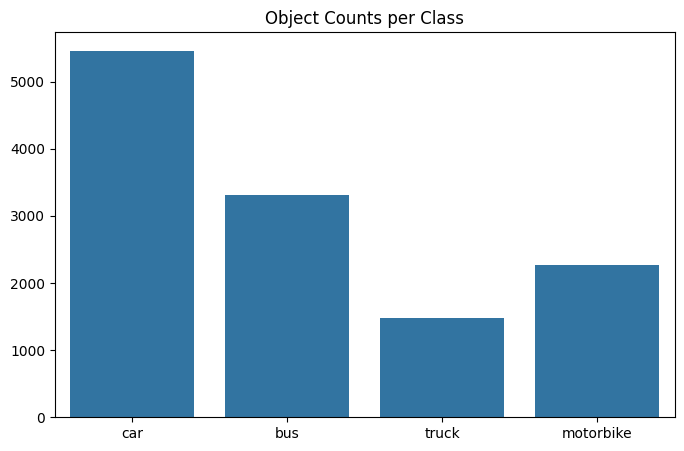

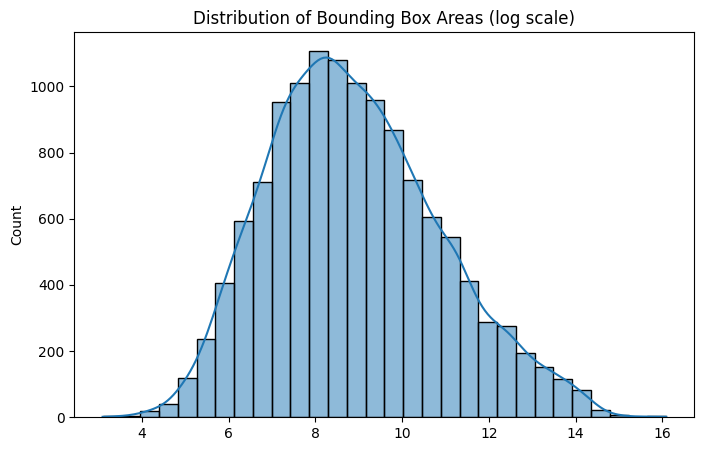

In [8]:
class_counts = {cls: 0 for cls in selected_classes}
areas = []

for xml_file in xml_files:
    info = extract_info_from_xml(xml_file)
    if info:
        iw, ih, _ = info['image_size']
        for b in info['bboxes']:
            class_counts[b['class']] += 1
            area = (b['xmax']-b['xmin']) * (b['ymax']-b['ymin'])
            areas.append(area)

plt.figure(figsize=(8,5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Object Counts per Class")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(np.log1p(areas), bins=30, kde=True)
plt.title("Distribution of Bounding Box Areas (log scale)")
plt.show()


In [9]:
from IPython import display
display.clear_output()

In [10]:
def load_dataset(root_dir):
    train_dir = os.path.join(root_dir, 'train')
    valid_dir = os.path.join(root_dir, 'valid')

    # Load training data
    train_images, train_annotations = load_data(train_dir)

    # Load validation data
    valid_images, valid_annotations = load_data(valid_dir)

    return train_images, train_annotations, valid_images, valid_annotations

In [11]:
def load_data(data_dir):
    image_paths = []
    annotation_paths = []

    # Collect image and annotation file paths
    for filename in os.listdir(data_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_paths.append(os.path.join(data_dir, filename))
            annotation_paths.append(os.path.join(data_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt')))

    # Load images
    images = [cv2.imread(img_path) for img_path in image_paths]

    # Load annotations
    annotations = [load_annotations(ann_path) for ann_path in annotation_paths]

    return images, annotations

In [12]:
def load_annotations(annotation_path):
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        # Assuming YOLO format: class, x_center, y_center, width, height
        annotations = [list(map(float, line.strip().split())) for line in lines]

    return np.array(annotations)


root_directory = r'./'
train_images, train_annotations, valid_images, valid_annotations = load_dataset(root_directory)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './valid'

In [ ]:
train_directory = r'D:\2025\hackthan\process\dataset\train'
files_in_directory = os.listdir(train_directory)
print(files_in_directory)

['images', 'labels']


In [ ]:
valid_directory = r'D:\2025\hackthan\process\dataset\val'
files_in_directory = os.listdir(valid_directory)
print(files_in_directory)

['labels', 'images']


In [ ]:
valid_directory = r'D:\2025\hackthan\process\dataset\test'
files_in_directory = os.listdir(valid_directory)
print(files_in_directory)

['labels', 'images']


In [ ]:
def load_sample_data(data_dir):
    image_dir = os.path.join(data_dir, 'images')
    label_dir = os.path.join(data_dir, 'labels')

    image_paths, label_paths = [], []

    # Collect image and label file paths
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_paths.append(os.path.join(image_dir, filename))
            label_paths.append(os.path.join(label_dir, filename.replace('.jpg', '.txt')))

    return image_paths, label_paths

In [ ]:
def load_annotations(annotation_path):
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        # Assuming YOLO format: class, x_center, y_center, width, height
        annotations = [list(map(float, line.strip().split())) for line in lines]

    return annotations

image_paths, annotation_paths = load_sample_data(train_directory)

In [ ]:
def count_files(directory):
    image_dir = os.path.join(directory, 'images')
    label_dir = os.path.join(directory, 'labels')

    image_count = len([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    label_count = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])

    return image_count, label_count

image_count, label_count = count_files(train_directory)

print(f"Number of images in the training set: {image_count}")
print(f"Number of labels in the training set: {label_count}")

Number of images in the training set: 2079
Number of labels in the training set: 2079


In [ ]:
# Print labels for the first 10 samples
for i in range(min(10, len(annotation_paths))):
    sample_annotations = load_annotations(annotation_paths[i])
    print(f"Labels for {annotation_paths[i]}:")
    print(sample_annotations)
    print("------------------------")

Labels for D:\2025\hackthan\process\dataset\train\labels\107.txt:
[[3.0, 0.3241, 0.614, 0.1411, 0.2147], [3.0, 0.6839, 0.5613, 0.0643, 0.1413]]
------------------------
Labels for D:\2025\hackthan\process\dataset\train\labels\108.txt:
[[1.0, 0.2402, 0.6173, 0.4768, 0.76]]
------------------------
Labels for D:\2025\hackthan\process\dataset\train\labels\109.txt:
[]
------------------------
Labels for D:\2025\hackthan\process\dataset\train\labels\112.txt:
[[1.0, 0.7826, 0.4292, 0.4347, 0.6792], [0.0, 0.4111, 0.424, 0.1361, 0.0813], [3.0, 0.2403, 0.513, 0.1111, 0.0969], [1.0, 0.1382, 0.3818, 0.1792, 0.1219], [0.0, 0.5389, 0.399, 0.0694, 0.0396], [1.0, 0.4986, 0.3667, 0.1, 0.0521], [1.0, 0.3111, 0.3594, 0.0833, 0.0292]]
------------------------
Labels for D:\2025\hackthan\process\dataset\train\labels\116.txt:
[[1.0, 0.5111, 0.4401, 0.8278, 0.7531]]
------------------------
Labels for D:\2025\hackthan\process\dataset\train\labels\117.txt:
[[0.0, 0.1951, 0.5375, 0.3875, 0.2375], [0.0, 0.7215

In [ ]:
image_paths, annotation_paths = load_sample_data(valid_directory)


for i in range(min(10, len(annotation_paths))):
    sample_annotations = load_annotations(annotation_paths[i])
    print(f"Labels for {annotation_paths[i]}:")
    print(sample_annotations)
    print("------------------------")

Labels for D:\2025\hackthan\process\dataset\test\labels\229.txt:
[[0.0, 0.3657, 0.6981, 0.1782, 0.1349], [1.0, 0.6134, 0.5096, 0.1181, 0.1073], [0.0, 0.1157, 0.8261, 0.2292, 0.2314], [0.0, 0.3646, 0.5885, 0.1065, 0.0751], [0.0, 0.3796, 0.5303, 0.0903, 0.0536], [0.0, 0.0544, 0.6084, 0.1065, 0.072], [3.0, 0.0185, 0.5513, 0.0347, 0.0467], [0.0, 0.1759, 0.5149, 0.0579, 0.0352], [1.0, 0.4815, 0.4391, 0.0394, 0.0368], [0.0, 0.3727, 0.4797, 0.0486, 0.0322], [3.0, 0.2025, 0.4759, 0.0278, 0.0276]]
------------------------
Labels for D:\2025\hackthan\process\dataset\test\labels\230.txt:
[[1.0, 0.3944, 0.5856, 0.1211, 0.2541], [0.0, 0.0559, 0.8204, 0.1087, 0.1713], [1.0, 0.3315, 0.5262, 0.1289, 0.268], [1.0, 0.4472, 0.3066, 0.0559, 0.0773], [1.0, 0.4402, 0.3895, 0.0637, 0.0939], [0.0, 0.257, 0.6547, 0.0761, 0.0884], [0.0, 0.927, 0.7624, 0.1118, 0.1215], [0.0, 0.177, 0.5152, 0.059, 0.058], [0.0, 0.0512, 0.7099, 0.0901, 0.0442], [0.0, 0.6095, 0.6644, 0.0792, 0.0746], [0.0, 0.1056, 0.4959, 0.0621, 0

In [ ]:
def load_sample_data(data_dir):
    image_dir = os.path.join(data_dir, 'images')
    label_dir = os.path.join(data_dir, 'labels')

    image_paths, label_paths = [], []

    # Collect image and label file paths
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_paths.append(os.path.join(image_dir, filename))
            label_paths.append(os.path.join(label_dir, filename.replace('.jpg', '.txt')))

    return image_paths, label_paths

def load_annotations(annotation_path):
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        # Assuming YOLO format: class, x_center, y_center, width, height
        annotations = [list(map(float, line.strip().split())) for line in lines]

    return annotations

In [ ]:
def display_sample(image_path, annotations):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for annotation in annotations:
        class_label, x_center, y_center, width, height = annotation
        x, y, w, h = x_center, y_center, width, height

        # Convert YOLO coordinates to bounding box coordinates
        x *= image.shape[1]
        y *= image.shape[0]
        w *= image.shape[1]
        h *= image.shape[0]

        # Calculate top-left corner coordinates
        x -= w / 2
        y -= h / 2

        # Create a rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Display class label
        plt.text(x, y, f'{int(class_label)}', color='r')

    plt.show()


image_paths, annotation_paths = load_sample_data(train_directory)

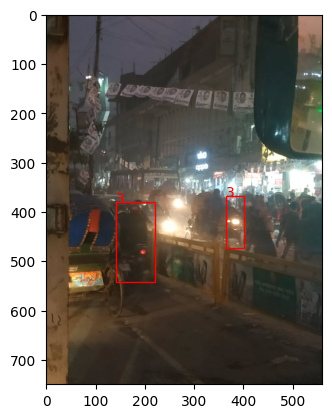

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\107.jpg


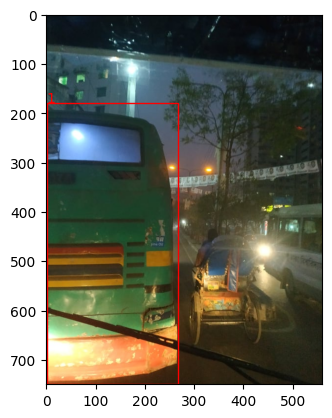

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\108.jpg


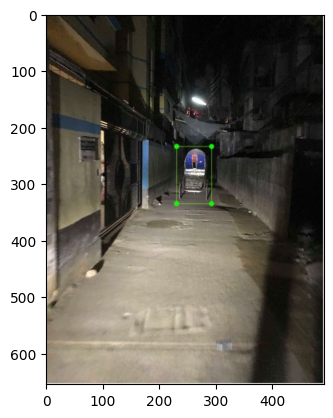

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\109.jpg


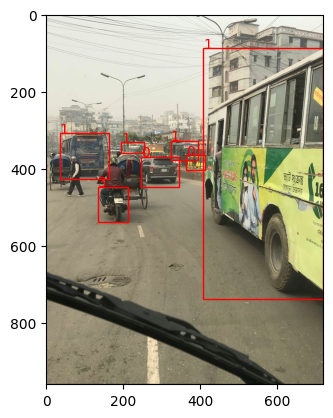

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\112.jpg


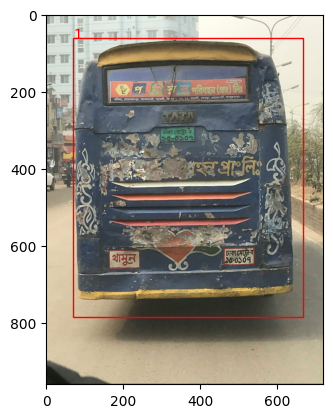

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\116.jpg


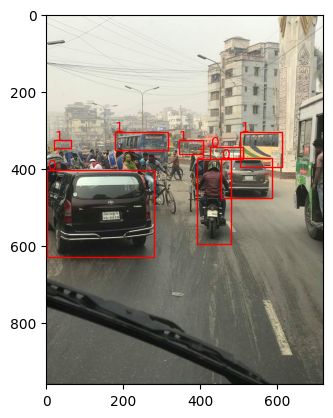

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\117.jpg


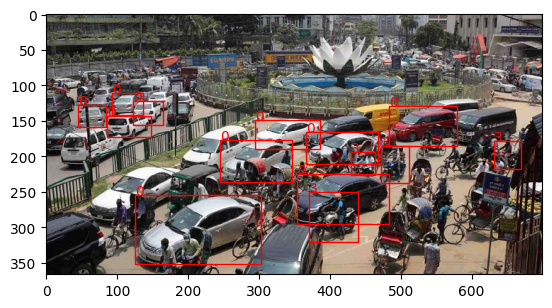

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\206.jpg


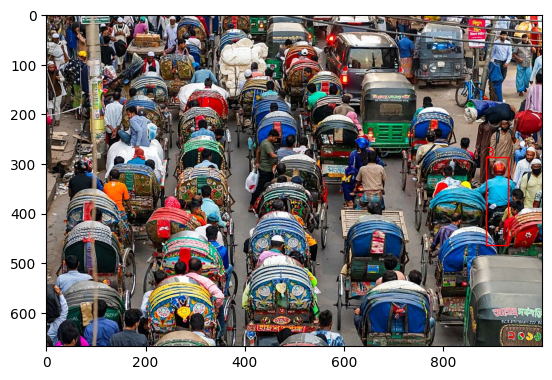

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\207.jpg


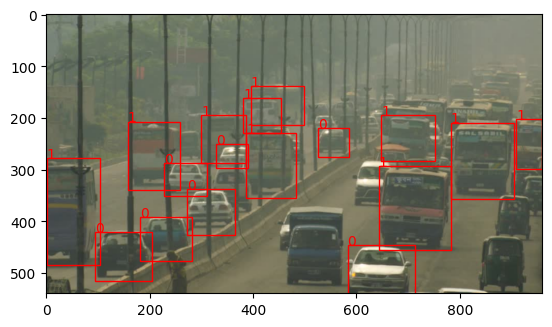

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\208.jpg


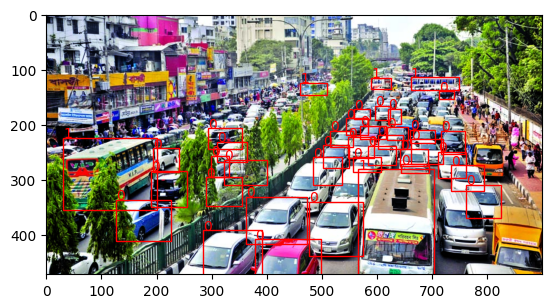

Annotations plotted for D:\2025\hackthan\process\dataset\train\images\209.jpg


In [ ]:
# Display and plot annotations for the first 10 images
for i in range(min(10, len(image_paths))):
    sample_image_path = image_paths[i]
    sample_annotations = load_annotations(annotation_paths[i])
    display_sample(sample_image_path, sample_annotations)
    print(f"Annotations plotted for {sample_image_path}")

In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image

In [ ]:
model=YOLO("yolo11n.pt")

In [ ]:
results=model.train(data=r"I:\2025\hackthan\process\vehicle_data.yaml",epochs=50,imgsz=640)

New https://pypi.org/project/ultralytics/8.3.204 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.160  Python-3.11.9 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i5-12400)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=I:\2025\hackthan\process\vehicle_data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset

train: Scanning I:\2025\hackthan\dataset\train\labels.cache... 2079 images, 255 backgrounds, 106 corrupt: 100%|██████████| 2291/2291 [00:00<?, ?it/s]

train: I:\2025\hackthan\dataset\train\labels\Dipto_ 330.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\train\\labels\\Dipto_ 330.JPG'
train: I:\2025\hackthan\dataset\train\labels\Dipto_344.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\train\\labels\\Dipto_344.JPG'
train: I:\2025\hackthan\dataset\train\labels\Dipto_345.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\train\\labels\\Dipto_345.JPG'
train: I:\2025\hackthan\dataset\train\labels\Dipto_346.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\train\\labels\\Dipto_346.JPG'
train: I:\2025\hackthan\dataset\train\labels\Dipto_349.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\train\\labels\\Dipto_349.JPG'
train: I:\2025\hackthan\dataset\train\labels\Dipto_525.JPG: ignoring corrupt image/label: cannot identify image f


c:\Program Files\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


val: Fast image access  (ping: 0.20.1 ms, read: 10.16.2 MB/s, size: 523.4 KB)


val: Scanning I:\2025\hackthan\dataset\val\labels.cache... 259 images, 30 backgrounds, 14 corrupt: 100%|██████████| 287/287 [00:00<?, ?it/s]

val: I:\2025\hackthan\dataset\val\labels\Dipto_348.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\val\\labels\\Dipto_348.JPG'
val: I:\2025\hackthan\dataset\val\labels\Dipto_536.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\val\\labels\\Dipto_536.JPG'
val: I:\2025\hackthan\dataset\val\labels\Navid_230.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\val\\labels\\Navid_230.JPG'
val: I:\2025\hackthan\dataset\val\labels\Navid_578.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\val\\labels\\Navid_578.JPG'
val: I:\2025\hackthan\dataset\val\labels\Navid_584.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\val\\labels\\Navid_584.JPG'
val: I:\2025\hackthan\dataset\val\labels\Navid_585.JPG: ignoring corrupt image/label: cannot identify image file 'I:\\2025\\hackthan\\dataset\\va


c:\Program Files\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.391      2.723      1.177         36        640: 100%|██████████| 137/137 [08:40<00:00,  3.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:26<00:00,  2.97s/it]

                   all        273        897      0.548      0.307      0.371      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.434      1.994      1.205         50        640: 100%|██████████| 137/137 [05:52<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.55s/it]

                   all        273        897       0.54      0.384      0.404      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.472      1.918      1.236         89        640: 100%|██████████| 137/137 [05:51<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.47s/it]

                   all        273        897      0.472      0.393      0.391      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.469      1.825      1.231         95        640: 100%|██████████| 137/137 [05:56<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        273        897      0.493      0.432      0.421      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.424      1.615      1.214         85        640: 100%|██████████| 137/137 [05:54<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:13<00:00,  1.44s/it]

                   all        273        897      0.527      0.469      0.452      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.387      1.555      1.193         50        640: 100%|██████████| 137/137 [05:56<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        273        897      0.604      0.489      0.509      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.365      1.458       1.18         29        640: 100%|██████████| 137/137 [05:56<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897       0.52      0.498      0.498       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.348      1.392       1.16         55        640: 100%|██████████| 137/137 [05:56<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.552      0.501      0.509      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.344      1.373      1.156         69        640: 100%|██████████| 137/137 [05:56<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        273        897      0.594      0.503       0.53      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.317      1.342       1.15         68        640: 100%|██████████| 137/137 [05:53<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        273        897      0.661      0.507      0.562      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.289      1.268      1.136         45        640: 100%|██████████| 137/137 [05:55<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.605      0.513      0.549       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.276      1.254       1.13         92        640: 100%|██████████| 137/137 [05:58<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.652       0.51      0.567      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.273      1.238      1.119         18        640: 100%|██████████| 137/137 [05:59<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.629      0.551      0.591      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.256      1.209       1.12         81        640: 100%|██████████| 137/137 [05:57<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.642      0.546      0.595      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.246      1.196      1.111         51        640: 100%|██████████| 137/137 [05:59<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]

                   all        273        897      0.693      0.535      0.599      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.233       1.15      1.097         63        640: 100%|██████████| 137/137 [05:58<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.648      0.503      0.569      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.227      1.144      1.102         72        640: 100%|██████████| 137/137 [05:56<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        273        897      0.641       0.55      0.584      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.201      1.107      1.091         60        640: 100%|██████████| 137/137 [05:58<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.44s/it]

                   all        273        897      0.693      0.559      0.627      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.177      1.086      1.079         43        640: 100%|██████████| 137/137 [06:01<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.687      0.572      0.621      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.161      1.076      1.078         65        640: 100%|██████████| 137/137 [05:59<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897       0.68      0.581      0.628      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G       1.19      1.078      1.077        103        640: 100%|██████████| 137/137 [05:56<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.686      0.595      0.648      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.181      1.054      1.079         88        640: 100%|██████████| 137/137 [05:58<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]

                   all        273        897      0.679      0.589      0.645      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.162      1.035       1.07         45        640: 100%|██████████| 137/137 [06:01<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.714      0.601      0.673       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.142      1.001      1.059         45        640: 100%|██████████| 137/137 [05:57<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.743      0.581      0.672       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.143     0.9974      1.056         54        640: 100%|██████████| 137/137 [05:57<00:00,  2.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.733      0.585      0.675      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.126     0.9833      1.055         48        640: 100%|██████████| 137/137 [05:56<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.694      0.599      0.665      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.126     0.9649      1.042         41        640: 100%|██████████| 137/137 [05:55<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.671      0.571      0.649      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.113     0.9584      1.042         48        640: 100%|██████████| 137/137 [06:01<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.745       0.58      0.684      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.112     0.9416      1.043         67        640: 100%|██████████| 137/137 [05:58<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]

                   all        273        897      0.738      0.592      0.683      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.097     0.9278      1.037         71        640: 100%|██████████| 137/137 [06:01<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]

                   all        273        897      0.746        0.6      0.698      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.076     0.9074      1.029         67        640: 100%|██████████| 137/137 [05:59<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.715      0.623       0.69      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.089     0.9017      1.031         38        640: 100%|██████████| 137/137 [06:02<00:00,  2.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.763      0.616      0.698      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G       1.09     0.9032      1.032         63        640: 100%|██████████| 137/137 [05:59<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.709      0.594      0.687      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.069     0.8824      1.028         75        640: 100%|██████████| 137/137 [06:03<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.723      0.613      0.696      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G       1.06     0.8698      1.024         73        640: 100%|██████████| 137/137 [05:52<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.725      0.619      0.704      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.053     0.8593      1.016         62        640: 100%|██████████| 137/137 [05:50<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.752      0.618       0.71      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G       1.04     0.8453      1.012        130        640: 100%|██████████| 137/137 [05:49<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]

                   all        273        897      0.746      0.586       0.69      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.033     0.8351      1.009         38        640: 100%|██████████| 137/137 [05:56<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.723       0.62      0.706      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.017     0.8146      1.004         54        640: 100%|██████████| 137/137 [05:54<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.712      0.647      0.713       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.031     0.8238       1.01         52        640: 100%|██████████| 137/137 [05:53<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.738      0.647      0.725      0.481


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Program Files\Python311\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      41/50         0G      1.015     0.7733     0.9843         21        640: 100%|██████████| 137/137 [05:46<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.707      0.639      0.698      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.004     0.7384     0.9882         43        640: 100%|██████████| 137/137 [05:47<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.722      0.652      0.714      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9923     0.7288     0.9851         26        640: 100%|██████████| 137/137 [05:48<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.724      0.637      0.714      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.9808     0.7223     0.9727         83        640: 100%|██████████| 137/137 [05:47<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.758      0.617      0.713      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.9655     0.6948     0.9723         28        640: 100%|██████████| 137/137 [05:49<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.729       0.64      0.713      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.9636      0.689     0.9648         29        640: 100%|██████████| 137/137 [05:49<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897       0.74      0.656      0.714      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.9508     0.6814     0.9675         33        640: 100%|██████████| 137/137 [05:46<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.758      0.666       0.73      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.9536     0.6716     0.9587         25        640: 100%|██████████| 137/137 [05:47<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]

                   all        273        897      0.756      0.634      0.723      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.9342     0.6618     0.9553         31        640: 100%|██████████| 137/137 [05:49<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.42s/it]

                   all        273        897      0.754      0.648      0.727      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.9335      0.658     0.9503         35        640: 100%|██████████| 137/137 [05:49<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]

                   all        273        897      0.764      0.646      0.728       0.48



50 epochs completed in 5.203 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 5.4MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 5.4MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.160  Python-3.11.9 torch-2.7.1+cpu CPU (12th Gen Intel Core(TM) i5-12400)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


                   all        273        897      0.759      0.666       0.73      0.484
                   car        138        338      0.711      0.716      0.752      0.547
                   bus        130        248       0.78       0.73      0.774      0.549
                 truck         83        155      0.777      0.673      0.732       0.52
             motorbike         88        156      0.768      0.545       0.66      0.321
Speed: 0.5ms preprocess, 26.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\train2


In [ ]:
from ipywidgets import FileUpload, Output
from IPython.display import display, Image
from ultralytics import YOLO
import cv2
import numpy as np

# Load the YOLO model
model = YOLO("best.pt")

# Create file upload widget
file_upload = FileUpload(accept='image/*', multiple=False)  # Only accept image files
output = Output()

def on_upload_change(change):
    # Clear previous output
    output.clear_output()
    
    # Retrieve the uploaded file
    if isinstance(file_upload.value, dict):  # Check if value is a dict (older versions)
        uploaded_file = list(file_upload.value.values())[0]
        content = uploaded_file['content']
        filename = uploaded_file['metadata']['name']
    elif isinstance(file_upload.value, tuple):  # Check for tuple (newer versions)
        uploaded_file = file_upload.value[0]
        content = uploaded_file['content']
        filename = uploaded_file['name']
    else:
        with output:
            print("Unrecognized file_upload structure!")
        return
    
    # Save the uploaded file temporarily
    temp_path = f"./{filename}"
    with open(temp_path, 'wb') as f:
        f.write(content)
    
    # Load the image with OpenCV
    image = cv2.imdecode(np.frombuffer(content, np.uint8), cv2.IMREAD_COLOR)
    
    # Perform YOLO prediction
    results = model.predict(source=image, show=False)  # Disable display in this function
    
    # Draw bounding boxes on the image
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            class_id = int(box.cls[0])  # Class ID
            class_name = model.names[class_id]  # Get class name from ID
            confidence = box.conf[0]  # Confidence score
            
            # Draw the bounding box and label
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box
            label = f"{class_name} ({confidence:.2f})"
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display detected classes and the image with bounding boxes
    with output:
        print("Detected Classes:")
        for result in results:
            for box in result.boxes:
                class_id = int(box.cls[0])  # Class ID
                class_name = model.names[class_id]  # Get class name from ID
                print(class_name)
        
        # Convert image to JPEG for display
        _, encoded_img = cv2.imencode('.jpg', image)
        display(Image(data=encoded_img.tobytes(), format='jpg'))

# Attach event listener to the file upload widget
file_upload.observe(on_upload_change, names='value')

# Display widgets
display(file_upload, output)


FileUpload(value=(), accept='image/*', description='Upload')

Output()